In [14]:
import argparse
import time
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from unet import ResidualUNet, Denoiser
from utils import save_image, dotdict
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

In [27]:
class DDPM:
    def __init__(self, model, timesteps=1000, beta_start=0.0001, beta_end=0.02, n_skip = 0, lr = 2e-4):
        self.model = model
        self.timesteps = timesteps-n_skip
        self.reversed_time_steps = torch.arange(self.timesteps-1,-1,-1)
        #print(self.reversed_time_steps)
        self.betas = torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32, device=device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
        self.alphas = self.alphas[n_skip:]
        self.betas = self.betas[n_skip:]
        self.alphas_cumprod = self.alphas_cumprod[n_skip:]
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        print(self.alphas_cumprod)

    def forward(self,data, model, alphasb_batch = None):
        im = data
    
        # parameters of the langevin dynamics steps
        ind_randoms= torch.randint(0, self.timesteps, (data.shape[0],), device = data.device)
        
        noise_in = torch.randn_like(im)
        if alphasb_batch is None:
            alphasb_batch = self.alphas_cumprod[ind_randoms]
    
            im_input = (torch.sqrt(1-alphasb_batch)[:,None,None,None]*noise_in+torch.sqrt(alphasb_batch)[:,None,None,None]*im)
        else :
            im_input = im
        
        pred_eps = model(im_input, alphasb_batch)
        score = -pred_eps/torch.sqrt(1-alphasb_batch)[:,None,None,None]
        # corrected image 
        im_corrected = (im_input-torch.sqrt(1-alphasb_batch)[:,None,None,None]*pred_eps)/torch.sqrt(alphasb_batch)[:,None,None,None]
    
        square_norm = torch.sum((pred_eps-noise_in)**2,(1,2,3)) # square norm of loss per image
        loss = square_norm.sum()
        return loss, im_input, im_corrected, pred_eps, score
                

    def sample_sde(self, num_samples, shape=(1,32,32), corr = True):
        with torch.no_grad():  # avoid backprop wrt model parameters
            x = torch.randn((num_samples,)+shape, dtype=torch.float32, device=device)
            for i, t in enumerate(self.reversed_time_steps):
                
                t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
                alphasb_batch = self.alphas_cumprod[t_tensor]
                loss, im_input, im_corrected, eps, score= self.forward(x, self.model, alphasb_batch)

                alpha_t = self.alphas[t]
                alpha_t_cumprod = self.alphas_cumprod[t]
                beta_t = self.betas[t]

                mean = 1/(torch.sqrt(alpha_t))*(x-(beta_t/torch.sqrt(1-alpha_t_cumprod))*eps)

                noise = torch.randn_like(x)
                x = mean + torch.sqrt(beta_t) * noise
                if t==0 and corr:
                    print("last corr")
                    x = im_corrected
        return x

    def sample_ode(self, num_samples, shape=(1,32,32), corr = True):
        with torch.no_grad(): # avoid backprop wrt model parameters
            x = torch.randn((num_samples,)+shape, dtype=torch.float32, device=device)
            for i, t in enumerate(self.reversed_time_steps):
                
                #TODO
                t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
                x = self.ode_step(x,t_tensor)
        return x
        
    def ode_step(self, x, t_tensor, corr = True):
        with torch.no_grad():
            alphasb_batch = self.alphas_cumprod[t_tensor]
            loss, im_input, im_corrected, pred_eps, score= self.forward(x, self.model, alphasb_batch)
            beta_t = self.betas[t_tensor]
            xip = (2-torch.sqrt(1-beta_t))[:,None,None,None]*x+1/2*beta_t[:,None,None,None]*score
            x = xip# + torch.sqrt(beta_t)*noise
            if corr:
                x = torch.where((t_tensor==0)[:,None,None,None],im_corrected,x)
        return x
    

    def load(self, path):
        """Load the model's state from a file."""
        self.model.load_state_dict(torch.load(path, map_location=next(model.parameters()).device))

    def store(self, path):
        """Store the model's state to a file."""
        torch.save(self.model.state_dict(), path)

    def add_noise(self,batch,t_tensor):
        noise = torch.randn_like(batch, dtype=torch.float32)
        noisy_data = torch.sqrt(self.alphas_cumprod[t_tensor]).view(-1, 1,1,1) * batch + torch.sqrt(1.0 - self.alphas_cumprod[t_tensor]).view(-1, 1,1,1) * noise
        return noise

    def train(self, dataloader, epochs=1000, batch_size=64):
        criterion = nn.MSELoss()
        
        losses = []
        mean_loss = 0
        i = 0

        for epoch in range(epochs):
            
            for x, idx in tqdm(dataloader):
                x = x.to(device)
                self.optimizer.zero_grad()
                loss, im_input, im_corrected, pred_eps, score= self.forward(x, self.model)
                mean_loss+=loss.item()
                i+=1
                loss.backward()
                self.optimizer.step()

            if epoch % 1 == 0:
                losses.append(mean_loss/i)
                print(f'Epoch {epoch}, Loss: {mean_loss/i}')
                mean_loss = 0
                i = 0
        return losses
    


In [34]:

TEST = False# set to true to load model from disk and only generate to test langevin

# Training settings
args_dict = {'batch_size' : 64, 'test_batch_size' :64, 'epochs' :1000, 'lr' : 0.0002, 'gamma' : 0.995, 'no_cuda' :False, 
             'dry_run':False, 'seed': 1, 'log_interval' : 200, 'save_model' :True, 'only_test':False, 'model_path':"models/denoisermnist-Copy1.pt", 
             'load_model_from_disk':True, 'dataset':"MNIST", 'test':False}
args = dotdict(args_dict)
#parser = argparse.ArgumentParser(description="A simple argument parser example.")

# Add arguments
#parser.add_argument('--dataset', type=str, required=False, default = 'MNIST', help='Dataset can be one of MNIST, CIFAR, CELEBA')
#parser.add_argument('--test', type= str, required = False, help='wether to only test a model, requires path to the testing weights')

# Parse the arguments
#margs = parser.parse_args()
#args.dataset = margs.dataset
#if margs.test is not None:
#    print("TEST")
#    args.test = True
#    print(args.test)
#    args.model_path = margs.test

if args.test:
    print("TEST")
    args.load_model_from_disk = True
    args.only_test = True
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

dataset = args.dataset
if dataset == "CIFAR":
    transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),#mean, std
    transforms.RandomHorizontalFlip(p=0.5)
    ])

    dataset1 = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform)
    dataset2 = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    model = Denoiser(4,3).to(device)
elif dataset == "CELEBA":
    transform = transforms.Compose([transforms.Resize((64,64)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                    std=[0.5, 0.5, 0.5])])
    dataset1 = datasets.CelebA("./data/celeba", split = 'train',download=False, transform=transform)
    dataset2 = datasets.CelebA("./data/celeba", split = 'test', download=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    model = Denoiser(3,3).to(device)

elif dataset=="MNIST":
    # loading dataset
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset1 = datasets.MNIST('./data/mnist', train=True, download=True,
    transform=transform)
    dataset2 = datasets.MNIST('./data/mnist', train=False,
    transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Denoiser(1,1).to(device)

if args.load_model_from_disk:
    model.load_state_dict(torch.load(args.model_path, weights_only= True))

ddpm = DDPM(model, timesteps=100, beta_start = 2e-3, beta_end = 0.15, n_skip=5)

tensor([9.6605e-01, 9.5545e-01, 9.4354e-01, 9.3037e-01, 9.1599e-01, 9.0046e-01,
        8.8386e-01, 8.6623e-01, 8.4767e-01, 8.2823e-01, 8.0800e-01, 7.8706e-01,
        7.6548e-01, 7.4335e-01, 7.2075e-01, 6.9776e-01, 6.7446e-01, 6.5093e-01,
        6.2724e-01, 6.0348e-01, 5.7972e-01, 5.5603e-01, 5.3248e-01, 5.0912e-01,
        4.8603e-01, 4.6326e-01, 4.4087e-01, 4.1889e-01, 3.9739e-01, 3.7640e-01,
        3.5595e-01, 3.3608e-01, 3.1682e-01, 2.9819e-01, 2.8021e-01, 2.6289e-01,
        2.4625e-01, 2.3030e-01, 2.1503e-01, 2.0046e-01, 1.8657e-01, 1.7337e-01,
        1.6084e-01, 1.4898e-01, 1.3777e-01, 1.2719e-01, 1.1724e-01, 1.0789e-01,
        9.9128e-02, 9.0928e-02, 8.3270e-02, 7.6132e-02, 6.9492e-02, 6.3328e-02,
        5.7616e-02, 5.2332e-02, 4.7455e-02, 4.2962e-02, 3.8830e-02, 3.5037e-02,
        3.1562e-02, 2.8385e-02, 2.5485e-02, 2.2844e-02, 2.0441e-02, 1.8261e-02,
        1.6287e-02, 1.4501e-02, 1.2890e-02, 1.1438e-02, 1.0133e-02, 8.9610e-03,
        7.9116e-03, 6.9732e-03, 6.1357e-

In [24]:
ddpm.train(train_loader)

100%|█████████████████████████████| 938/938 [00:48<00:00, 19.48it/s]


Epoch 0, Loss: 1111.0791647449485


100%|█████████████████████████████| 938/938 [00:48<00:00, 19.50it/s]


Epoch 1, Loss: 1121.4403169221207


100%|█████████████████████████████| 938/938 [00:48<00:00, 19.54it/s]


Epoch 2, Loss: 1107.46747418304


100%|█████████████████████████████| 938/938 [00:48<00:00, 19.49it/s]


Epoch 3, Loss: 1107.7887200719513


100%|█████████████████████████████| 938/938 [00:48<00:00, 19.49it/s]


Epoch 4, Loss: 1103.865781544114


 19%|█████▌                       | 179/938 [00:09<00:39, 19.20it/s]


KeyboardInterrupt: 

In [3]:
def plot_mnist_batch(images_tensor, n_images=64):
    # Move the tensor to CPU and convert to NumPy
    images_cpu = images_tensor.cpu().numpy()

    # Assuming the tensor shape is (batch_size, 1, 28, 28)
    # Plot the first n_images in the batch
    fig, axes = plt.subplots(8,8, figsize=(10, 10))
    for i in range(n_images):
        ax = axes[i//8,i%8]
        ax.imshow(images_cpu[i, 0], cmap='gray')
        ax.axis('off')
    plt.show()


In [35]:
images = ddpm.sample_ode(64)
#images_corr = ddpm.sample_sde(64, corr=False)

/tmp/ipykernel_1362383/2718324852.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)


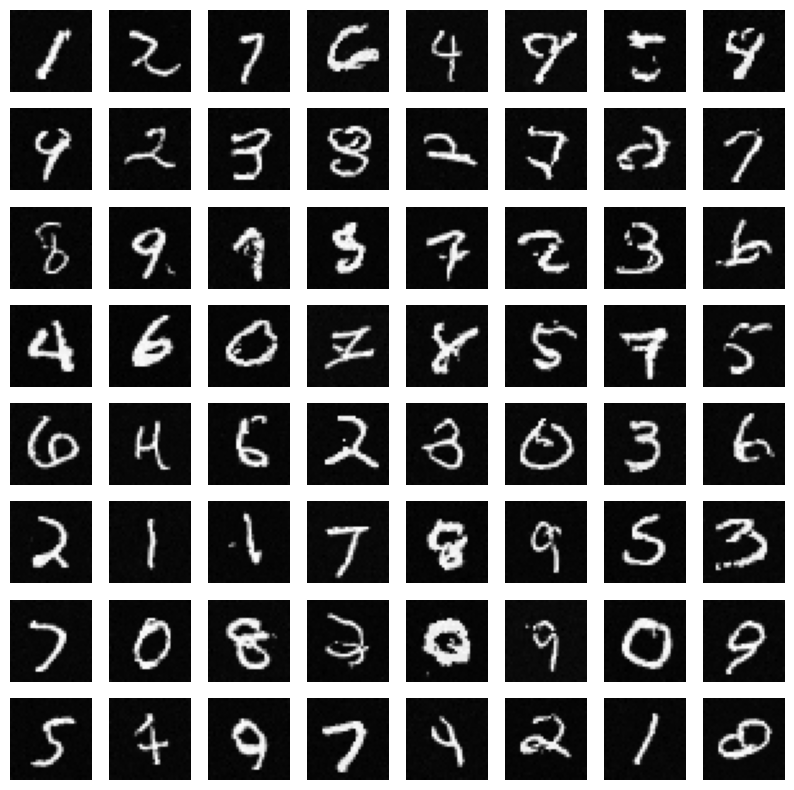

In [36]:
plot_mnist_batch(images)

In [41]:
import copy
from tqdm import tqdm
class ConsistencyModel:
    def __init__(self, student_model, teacher_model, timesteps=80, learning_rate=1e-4, mu=0.95):
        self.student_model = student_model  # Consistency model
        self.teacher_model = teacher_model  # Pretrained DDPM model
        self.timesteps =  teacher_model.timesteps
        self.learning_rate = learning_rate
        self.mu = mu  # EMA parameter
        self.optimizer = optim.Adam(self.student_model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        
        self.theta_minus_model = self.create_ema_model()
    
    def create_ema_model(self):
        """ Create a copy of the student model for EMA tracking """
        ema_model = copy.deepcopy(self.student_model)
        for param in ema_model.parameters():
            param.requires_grad = False  # Freeze EMA model
        return ema_model.to(device)
    
    def update_ema(self):
        """ Exponential Moving Average (EMA) update for θ⁻ """
        with torch.no_grad():
            for param, param_ema in zip(self.student_model.parameters(), self.theta_minus_model.parameters()):
                param_ema.data = self.mu * param_ema.data + (1 - self.mu) * param.data

    def sample(self,num_samples, im_shape):
        x = torch.randn((num_samples,)+im_shape, dtype=torch.float32, device=device)
        with torch.no_grad():
            return self.student_model(x, self.teacher_model.alphas_cumprod[-1]*torch.ones((num_samples,), device = device))
        
        
    def load(self, path):
        """Load the model's state from a file."""
        self.student_model.load_state_dict(torch.load(path, map_location=next(student_model.parameters()).device))

    def store(self, path):
        """Store the model's state to a file."""
        torch.save(self.student_model.state_dict(), path)

    def train(self, train_loader, test_loader, epochs=1000, batch_size=64):
        for epoch in range(epochs):
            epoch_loss = 0
            for x,label in tqdm(train_loader):
                x = x.to(device)
                self.optimizer.zero_grad()
                
                # Sample t_n and t_{n+1}
                n = torch.randint(0, self.timesteps - 2, (x.size(0),), device=x.device)
                t_n = n   # Select t_n
                
                t_np1 = t_n+1  # Select t_n+1
                
                # Sample x_{t_{n+1}}
                #noise = torch.randn_like(x, device=x.device)
                
                x_tnp1 = self.teacher_model.add_noise(x, t_np1)
                alphas_cumprod_t = self.teacher_model.alphas_cumprod[t_n]
                alphas_cumprod_tp1 = self.teacher_model.alphas_cumprod[t_np1]
                
                # Compute teacher output (ODE solver)
                with torch.no_grad():
                    x_hat_tn = self.teacher_model.ode_step(x_tnp1, t_np1)
                    #x_hat_phi_tn = x_tnp1 - t_np1.view(-1, 1) * (t_n.view(-1, 1) - t_np1.view(-1, 1)) * phi_tn
                
                # Compute student output
                student_output = self.student_model(x_tnp1, alphas_cumprod_tp1)
                
                with torch.no_grad():  # Stop gradient flow
                    #theta_minus_output = torch.where((t_n==0)[:,None,None,None],x,self.theta_minus_model(x_hat_tn, alphas_cumprod_t))
                    theta_minus_output=self.teacher_model.add_noise(x,t)
                
                # Compute loss
                loss = self.loss_fn(student_output, theta_minus_output)
                loss.backward()
                self.optimizer.step()
                
                # EMA update
                self.update_ema()
                
                epoch_loss += loss.item()
        
            print(f"Epoch {epoch}, Loss: {epoch_loss / len(train_loader)}")
            # Evaluate on test set every 2 epochs
            if epoch % 1 == 0:
                test_loss = 0
                with torch.no_grad():
                    for x, label in tqdm(test_loader):
                        x = x.to(device)
                        n = torch.randint(0, self.timesteps - 2, (x.size(0),), device=x.device)
                        t_n = n
                        t_np1 = t_n + 1
                        x_tnp1 = self.teacher_model.add_noise(x, t_np1)
                        alphas_cumprod_t = self.teacher_model.alphas_cumprod[t_n]
                        student_output = self.student_model(x_tnp1, alphas_cumprod_t)
                        theta_minus_output = self.theta_minus_model(x_tnp1, alphas_cumprod_t)
                        loss = self.loss_fn(student_output, theta_minus_output)
                        test_loss += loss.item()
                images = self.sample(64,(1,32,32))
                plot_mnist_batch(images)
        
                avg_test_loss = test_loss / len(test_loader)
                print(f"Epoch {epoch}, Test Loss: {avg_test_loss}")
        return self.student_model

In [42]:

student_model = Denoiser(1,1).to(device)
student_model.load_state_dict(model.state_dict())


<All keys matched successfully>

In [43]:
consistency_model = ConsistencyModel(student_model, ddpm)

In [44]:

student_model = consistency_model.train(train_loader, test_loader, epochs=100, batch_size=64)

  0%|                                       | 0/938 [00:00<?, ?it/s]


IndexError: tensors used as indices must be long, int, byte or bool tensors